In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


In [2]:
data = pd.read_csv('../data/5_interest_rate.csv')

In [3]:
data.drop(['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
         'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
         'k-사용검사일-사용승인일', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', 'k-전용면적별세대현황(60~85이하)',
         'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
         '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'], axis=1, inplace=True)

# 추가로 제거가 필요한 feature 제거 -> object타입 등
data.drop(['k-관리방식', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적',
         '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '시군구 번지', '좌표X,좌표Y', 'index', '역사_ID', '역사명', '위도', '경도',
         '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명',
         '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표'], axis=1, inplace=True)

In [4]:
'번지', '본번', '부번', '아파트명', '도로명', 

('번지', '본번', '부번', '아파트명', '도로명')

In [5]:
data.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리', '호선',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP',
       '한국은행 기준금리'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   시군구               1128094 non-null  object 
 1   번지                1127867 non-null  object 
 2   본번                1128019 non-null  float64
 3   부번                1128019 non-null  float64
 4   아파트명              1125958 non-null  object 
 5   전용면적              1128094 non-null  float64
 6   계약년월              1128094 non-null  int64  
 7   계약일               1128094 non-null  int64  
 8   층                 1128094 non-null  int64  
 9   건축년도              1128094 non-null  int64  
 10  도로명               1128094 non-null  object 
 11  좌표X               1128094 non-null  float64
 12  좌표Y               1128094 non-null  float64
 13  target            1118822 non-null  float64
 14  is_test           1128094 non-null  int64  
 15  가장 가까운 거리         1128094 non-null  float64
 16  

In [7]:
continuous_columns = []
categorical_columns = []

for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리', '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP', '한국은행 기준금리']
범주형 변수: ['시군구', '번지', '아파트명', '도로명', '호선']


In [8]:
data[categorical_columns] = data[categorical_columns].fillna('NULL')

data[continuous_columns] = data[continuous_columns].interpolate(method='linear', axis=0)

In [9]:
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')        
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])  
    return result

In [10]:
data = remove_outliers_iqr(data, '전용면적')

In [11]:
print(data.shape)

(1038846, 24)


In [12]:
data['구'] = data['시군구'].map(lambda x : x.split()[1])
data['동'] = data['시군구'].map(lambda x : x.split()[2])
del data['시군구']

data['계약년'] = data['계약년월'].astype('str').map(lambda x : x[:4])
data['계약월'] = data['계약년월'].astype('str').map(lambda x : x[4:])
del data['계약년월'] 

In [13]:
all = list(data['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)

In [14]:
is_gangnam = []
for x in data['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

data['강남여부'] = is_gangnam

In [15]:
data['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.038846e+06
mean     1.998583e+03
std      9.132471e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [16]:
data['신축여부'] = data['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [17]:
data.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '좌표X',
       '좌표Y', 'target', 'is_test', '가장 가까운 거리', '호선', '인근 지하철 역 개수',
       '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP', '한국은행 기준금리',
       '구', '동', '강남여부', '신축여부'],
      dtype='object')

In [18]:
train_df = data[data['is_test'] == 0].drop(columns=['is_test'])
test_df = data[data['is_test'] == 1].drop(columns=['is_test'])


print("Train DataFrame")
print(train_df.shape)
print(train_df.head())

print("Test DataFrame")
print(test_df.shape)
print(test_df.head())

Train DataFrame
(1029574, 25)
      번지     본번   부번    아파트명   전용면적  계약일  층  건축년도    도로명        좌표X  ...  \
0  658-1  658.0  1.0  개포6차우성  79.97    8  3  1987  언주로 3  127.05721  ...   
1  658-1  658.0  1.0  개포6차우성  79.97   22  4  1987  언주로 3  127.05721  ...   
2  658-1  658.0  1.0  개포6차우성  54.98   28  5  1987  언주로 3  127.05721  ...   
3  658-1  658.0  1.0  개포6차우성  79.97    3  4  1987  언주로 3  127.05721  ...   
4  658-1  658.0  1.0  개포6차우성  79.97    8  2  1987  언주로 3  127.05721  ...   

   가장 가까운 버스 정류장 거리  인근 버스 정류장 개수   계약년 계약월        GDP  한국은행 기준금리    구    동  \
0          61.89584           7.0  2017  12  1623074.1        1.5  강남구  개포동   
1          61.89584           7.0  2017  12  1623074.1        1.5  강남구  개포동   
2          61.89584           7.0  2017  12  1623074.1        1.5  강남구  개포동   
3          61.89584           7.0  2018  01  1725373.4        1.5  강남구  개포동   
4          61.89584           7.0  2018  01  1725373.4        1.5  강남구  개포동   

  강남여부  신축여부  
0    1     0  
1    1  

In [19]:
y_train = train_df['target']
X_train = train_df.drop(['target'], axis=1)
test_df = test_df.drop(columns=['target'])

In [20]:
train_df.shape

(1029574, 25)

In [21]:
test_df.shape

(9272, 24)

In [22]:
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['본번', '부번', '전용면적', '계약일', '층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리', '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', 'GDP', '한국은행 기준금리', '강남여부', '신축여부']
범주형 변수: ['번지', '아파트명', '도로명', '호선', '계약년', '계약월', '구', '동']


In [23]:
label_encoders = {}

for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    lbl.fit(train_df[col].astype(str) )
    train_df[col] = lbl.transform(train_df[col].astype(str))
    label_encoders[col] = lbl         

    for label in np.unique(test_df[col]):
      if label not in lbl.classes_: 
        lbl.classes_ = np.append(lbl.classes_, label)

    test_df[col] = lbl.transform(test_df[col].astype(str))

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:02<00:00,  3.87it/s]


In [24]:
y_train = train_df['target']
X_train = train_df.drop(['target'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=2023)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_continuous = X_train[continuous_columns_v2]
X_val_continuous = X_val[continuous_columns_v2]
test_df_continuous = test_df[continuous_columns_v2]

X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
X_val_continuous_scaled = scaler.transform(X_val_continuous)
test_df_continuous_scaled = scaler.transform(test_df_continuous)

X_train_continuous_scaled = pd.DataFrame(X_train_continuous_scaled, columns=continuous_columns_v2)
X_val_continuous_scaled = pd.DataFrame(X_val_continuous_scaled, columns=continuous_columns_v2)
test_df_continuous_scaled = pd.DataFrame(test_df_continuous_scaled, columns=continuous_columns_v2)

X_train = pd.concat([X_train_continuous_scaled, X_train[categorical_columns_v2].reset_index(drop=True)], axis=1)
X_val = pd.concat([X_val_continuous_scaled, X_val[categorical_columns_v2].reset_index(drop=True)], axis=1)
test_df = pd.concat([test_df_continuous_scaled, test_df[categorical_columns_v2].reset_index(drop=True)], axis=1)

print("Scaled Train DataFrame")
print(X_train.shape)
print(X_train.head())

print("Scaled Validation DataFrame")
print(X_val.shape)
print(X_val.head())

print("Scaled Test DataFrame")
print(test_df.shape)
print(test_df.head())

Scaled Train DataFrame
(978095, 24)
         본번        부번      전용면적       계약일         층      건축년도       좌표X  \
0 -1.082155 -0.118156 -1.122555 -0.894163 -0.478048 -0.719013  0.841221   
1  0.266740 -0.074602 -0.638664 -1.238320  1.961371  0.379944 -1.175484   
2 -0.572701 -0.118156  0.581753  1.056062 -0.303804 -0.609117 -0.666335   
3 -0.306396 -0.074602  1.901765  0.482467  0.393173  1.039318  1.581242   
4 -0.051669 -0.118156 -0.640607 -0.664725 -0.129560 -0.059639  1.578931   

        좌표Y  가장 가까운 거리  인근 지하철 역 개수  ...      강남여부      신축여부    번지  아파트명  \
0 -1.089918  -0.518417     0.108686  ...  1.352299 -0.365416   509  2970   
1 -1.643956  -0.195436    -1.105874  ... -0.739482 -0.365416  4520   660   
2  0.748915  -1.212873    -0.194954  ... -0.739482 -0.365416  2054   958   
3 -0.005889   0.090699    -0.802234  ...  1.352299 -0.365416  2979  1650   
4 -0.505371  -0.044760    -0.194954  ...  1.352299 -0.365416  3762  3357   

    도로명  호선  계약년  계약월   구    동  
0   437  17    4    7  

In [26]:
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [27]:
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 5217.666109910133


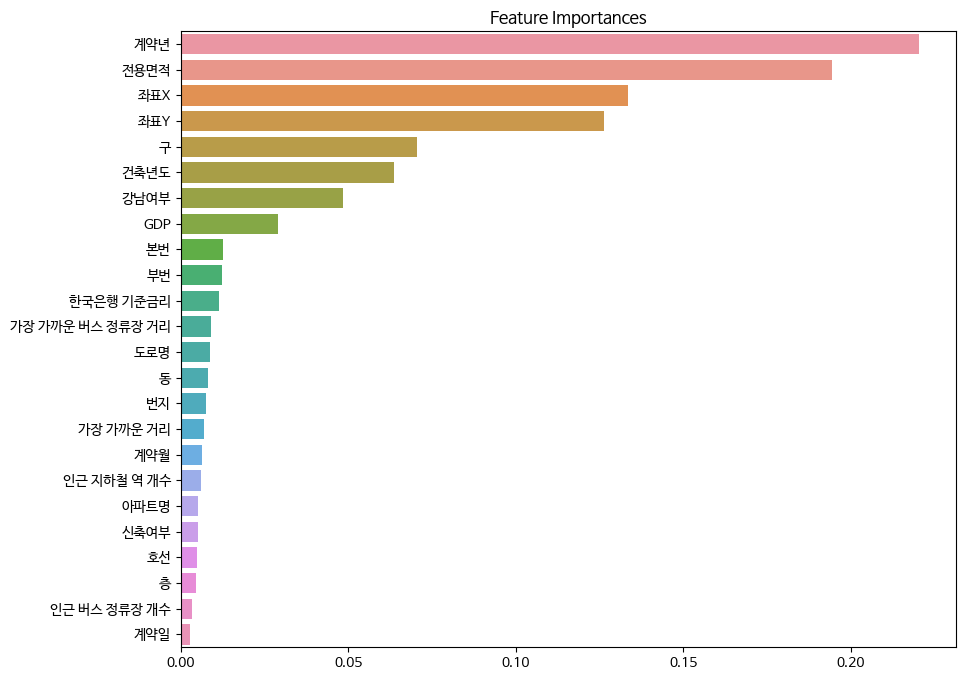

In [28]:
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [29]:
from xgboost import XGBRegressor

xgb = XGBRegressor(tree_method='gpu_hist', random_state=2023, n_estimators=10000, learning_rate=0.1)
xgb.fit(X_train, y_train,
        eval_set=[(X_val, y_val)])

predictions = xgb.predict(X_val)
predictions = [a if a > 0 else 0 for a in predictions]
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, predictions))}')

[0]	validation_0-rmse:34139.98527
[1]	validation_0-rmse:32027.62943
[2]	validation_0-rmse:30182.24207
[3]	validation_0-rmse:28392.94555
[4]	validation_0-rmse:26856.09311
[5]	validation_0-rmse:25454.53384
[6]	validation_0-rmse:24178.16987
[7]	validation_0-rmse:23110.61344
[8]	validation_0-rmse:22123.83817
[9]	validation_0-rmse:21151.47555
[10]	validation_0-rmse:20301.47495
[11]	validation_0-rmse:19572.51222
[12]	validation_0-rmse:18817.89819
[13]	validation_0-rmse:18154.97793
[14]	validation_0-rmse:17604.99811
[15]	validation_0-rmse:17033.81811
[16]	validation_0-rmse:16506.44123
[17]	validation_0-rmse:16074.72698
[18]	validation_0-rmse:15659.63703
[19]	validation_0-rmse:15272.23988
[20]	validation_0-rmse:14928.73762
[21]	validation_0-rmse:14629.01265
[22]	validation_0-rmse:14318.73424
[23]	validation_0-rmse:14072.59606
[24]	validation_0-rmse:13851.31512
[25]	validation_0-rmse:13636.08706
[26]	validation_0-rmse:13412.68266
[27]	validation_0-rmse:13159.89747
[28]	validation_0-rmse:12987.5

In [30]:
xgb_predictions = xgb.predict(test_df)

In [31]:
xgb_predictions

array([191156.61 , 256978.66 , 250315.53 , ...,  84001.05 ,  68624.586,
        73688.12 ], dtype=float32)

In [32]:
preds_df = pd.DataFrame(xgb_predictions.astype(int), columns=["target"])
preds_df.to_csv('xgb_nontune_output.csv', index=False)

In [33]:
import optuna
import warnings
warnings.filterwarnings('ignore')

In [34]:
def objective(trial, X, y, name='xgb'):
    params = {
        'tree_method': 'gpu_hist',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'eta': trial.suggest_float('eta', 1e-5, 0.1),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.009, 0.01, 0.012, 0.016, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [150, 200, 300, 500, 1000]),
        'max_depth': trial.suggest_categorical('max_depth', [4, 5, 7, 9, 11, 13, 17]),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state': 10
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    predictions_train = np.clip(model.predict(X_train), 0, None)
    predictions_val = np.clip(model.predict(X_val), 0, None)

    train_score = np.round(np.sqrt(metrics.mean_squared_error(y_train, predictions_train)), 5)
    test_score = np.round(np.sqrt(metrics.mean_squared_error(y_val, predictions_val)), 5)

    print(f'TRAIN RMSE : {train_score} || TEST RMSE : {test_score}')

    return test_score

In [36]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

best_params = study.best_trial.params
xgb = XGBRegressor(tree_method='gpu_hist', random_state=2023, **best_params)
xgb.fit(X_train, y_train,
        eval_set=[(X_val, y_val)])

xgb_predictions = np.clip(xgb.predict(X_val), 0, None)

rmse = np.sqrt(metrics.mean_squared_error(y_val, xgb_predictions))
print('Final Model RMSE :', rmse)

[I 2024-07-16 14:53:46,941] A new study created in memory with name: no-name-3bd0de02-7c88-42c7-b3a4-c9d0ba70104f
[I 2024-07-16 14:53:59,578] Trial 0 finished with value: 7915.00644 and parameters: {'lambda': 0.03675340835974803, 'alpha': 3.731261703047371, 'eta': 0.007219446126791702, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 13, 'min_child_weight': 234}. Best is trial 0 with value: 7915.00644.


TRAIN RMSE : 7502.16693 || TEST RMSE : 7915.00644


[I 2024-07-16 14:54:10,396] Trial 1 finished with value: 5788.59669 and parameters: {'lambda': 0.004213533090144648, 'alpha': 2.025300831800907, 'eta': 0.07074405041933755, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 11, 'min_child_weight': 187}. Best is trial 1 with value: 5788.59669.


TRAIN RMSE : 5330.66801 || TEST RMSE : 5788.59669


[I 2024-07-16 14:54:21,082] Trial 2 finished with value: 12644.04233 and parameters: {'lambda': 0.02973692504951537, 'alpha': 0.09696639720042459, 'eta': 0.04731205874392057, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 150, 'max_depth': 17, 'min_child_weight': 274}. Best is trial 1 with value: 5788.59669.


TRAIN RMSE : 12222.50479 || TEST RMSE : 12644.04233


[I 2024-07-16 14:54:23,437] Trial 3 finished with value: 12668.92823 and parameters: {'lambda': 9.492391742515476, 'alpha': 0.0038631152932339565, 'eta': 0.03621051603001265, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 26}. Best is trial 1 with value: 5788.59669.


TRAIN RMSE : 12462.43073 || TEST RMSE : 12668.92823


[I 2024-07-16 14:54:27,122] Trial 4 finished with value: 10926.01487 and parameters: {'lambda': 0.021123014551919957, 'alpha': 0.38483640952579634, 'eta': 0.09134044048438533, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 279}. Best is trial 1 with value: 5788.59669.


TRAIN RMSE : 10607.80074 || TEST RMSE : 10926.01487


[I 2024-07-16 14:54:29,410] Trial 5 finished with value: 11717.85786 and parameters: {'lambda': 0.029518047579842863, 'alpha': 0.29577532090132375, 'eta': 0.07089997051457952, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 274}. Best is trial 1 with value: 5788.59669.


TRAIN RMSE : 11469.97555 || TEST RMSE : 11717.85786


[I 2024-07-16 14:54:31,648] Trial 6 finished with value: 16759.62931 and parameters: {'lambda': 0.0024476742405859678, 'alpha': 6.930483033047014, 'eta': 0.06714404532425204, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 186}. Best is trial 1 with value: 5788.59669.


TRAIN RMSE : 16381.391 || TEST RMSE : 16759.62931


[I 2024-07-16 14:54:33,284] Trial 7 finished with value: 11821.49436 and parameters: {'lambda': 0.0013148224583453192, 'alpha': 0.6140206786644149, 'eta': 0.08866170302056478, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 5, 'min_child_weight': 222}. Best is trial 1 with value: 5788.59669.


TRAIN RMSE : 11650.49128 || TEST RMSE : 11821.49436


[I 2024-07-16 14:54:36,695] Trial 8 finished with value: 8799.0869 and parameters: {'lambda': 0.17353698823327063, 'alpha': 0.7309303858839169, 'eta': 0.03834742317650983, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 74}. Best is trial 1 with value: 5788.59669.


TRAIN RMSE : 8601.93737 || TEST RMSE : 8799.0869


[I 2024-07-16 14:54:38,421] Trial 9 finished with value: 12968.86421 and parameters: {'lambda': 0.1847104454054311, 'alpha': 8.513744369242568, 'eta': 0.05827284822715172, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 164}. Best is trial 1 with value: 5788.59669.


TRAIN RMSE : 12679.39338 || TEST RMSE : 12968.86421


[I 2024-07-16 14:54:56,940] Trial 10 finished with value: 4858.59302 and parameters: {'lambda': 1.1154762366036863, 'alpha': 0.01468023652819519, 'eta': 0.011695016617626099, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 111}. Best is trial 10 with value: 4858.59302.


TRAIN RMSE : 4262.65975 || TEST RMSE : 4858.59302


[I 2024-07-16 14:55:15,713] Trial 11 finished with value: 4842.69315 and parameters: {'lambda': 1.9956724743101657, 'alpha': 0.010956954688234353, 'eta': 0.0011221555646317508, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 103}. Best is trial 11 with value: 4842.69315.


TRAIN RMSE : 4233.0855 || TEST RMSE : 4842.69315


[I 2024-07-16 14:55:34,235] Trial 12 finished with value: 4879.0651 and parameters: {'lambda': 2.109139099758723, 'alpha': 0.009131486190845965, 'eta': 0.002168025022055094, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 109}. Best is trial 11 with value: 4842.69315.


TRAIN RMSE : 4273.22274 || TEST RMSE : 4879.0651


[I 2024-07-16 14:55:37,672] Trial 13 finished with value: 10750.92091 and parameters: {'lambda': 0.946625952916542, 'alpha': 0.02725077132198673, 'eta': 0.019605942655928583, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 107}. Best is trial 11 with value: 4842.69315.


TRAIN RMSE : 10584.53729 || TEST RMSE : 10750.92091


[I 2024-07-16 14:56:01,419] Trial 14 finished with value: 4444.64075 and parameters: {'lambda': 1.1830839674039766, 'alpha': 0.0011370249236250228, 'eta': 0.022678786406185432, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 7}. Best is trial 14 with value: 4444.64075.


TRAIN RMSE : 3512.77172 || TEST RMSE : 4444.64075


[I 2024-07-16 14:56:24,890] Trial 15 finished with value: 4555.4464 and parameters: {'lambda': 8.98022721165569, 'alpha': 0.0011655559354602771, 'eta': 0.023447923478125347, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 3}. Best is trial 14 with value: 4444.64075.


TRAIN RMSE : 3705.86439 || TEST RMSE : 4555.4464


[I 2024-07-16 14:56:44,621] Trial 16 finished with value: 4549.60242 and parameters: {'lambda': 8.976124812716147, 'alpha': 0.001788119342458304, 'eta': 0.025352541251816633, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 12}. Best is trial 14 with value: 4444.64075.


TRAIN RMSE : 3724.62021 || TEST RMSE : 4549.60242


[I 2024-07-16 14:57:14,458] Trial 17 finished with value: 5195.79218 and parameters: {'lambda': 0.41339672719462506, 'alpha': 0.0010260460842368261, 'eta': 0.030523856659251086, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 17, 'min_child_weight': 47}. Best is trial 14 with value: 4444.64075.


TRAIN RMSE : 4368.08756 || TEST RMSE : 5195.79218


[I 2024-07-16 14:57:44,146] Trial 18 finished with value: 4397.73195 and parameters: {'lambda': 3.5049322078637855, 'alpha': 0.003004666945153043, 'eta': 0.019291581022684946, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 55}. Best is trial 18 with value: 4397.73195.


TRAIN RMSE : 3480.52295 || TEST RMSE : 4397.73195


[I 2024-07-16 14:58:13,710] Trial 19 finished with value: 4405.62509 and parameters: {'lambda': 3.4582526344596585, 'alpha': 0.0035033993907578743, 'eta': 0.014820366644295976, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 60}. Best is trial 18 with value: 4397.73195.


TRAIN RMSE : 3506.62469 || TEST RMSE : 4405.62509


[I 2024-07-16 14:58:42,911] Trial 20 finished with value: 4427.30381 and parameters: {'lambda': 3.831132019398332, 'alpha': 0.06220488062280704, 'eta': 0.012496943377699412, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 63}. Best is trial 18 with value: 4397.73195.


TRAIN RMSE : 3540.48899 || TEST RMSE : 4427.30381


[I 2024-07-16 14:59:11,932] Trial 21 finished with value: 4427.80159 and parameters: {'lambda': 3.596854126693213, 'alpha': 0.0492395649067756, 'eta': 0.013530729701855614, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 66}. Best is trial 18 with value: 4397.73195.


TRAIN RMSE : 3556.06694 || TEST RMSE : 4427.80159


[I 2024-07-16 14:59:42,625] Trial 22 finished with value: 4361.49085 and parameters: {'lambda': 3.9280503276117513, 'alpha': 0.0038498981171989255, 'eta': 0.014227945950982313, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 49}. Best is trial 22 with value: 4361.49085.


TRAIN RMSE : 3411.61377 || TEST RMSE : 4361.49085


[I 2024-07-16 15:00:14,993] Trial 23 finished with value: 4287.52218 and parameters: {'lambda': 0.4374319541933494, 'alpha': 0.003869169316424268, 'eta': 0.04376934696210433, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 40}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 3279.47101 || TEST RMSE : 4287.52218


[I 2024-07-16 15:00:27,444] Trial 24 finished with value: 5570.70882 and parameters: {'lambda': 0.4887674290062673, 'alpha': 0.003172349994837056, 'eta': 0.04559253313865466, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 37}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 4947.61204 || TEST RMSE : 5570.70882


[I 2024-07-16 15:00:54,642] Trial 25 finished with value: 4612.71052 and parameters: {'lambda': 0.6059874359218586, 'alpha': 0.008123444134055654, 'eta': 0.057079075522647064, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 85}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 3770.78237 || TEST RMSE : 4612.71052


[I 2024-07-16 15:01:02,555] Trial 26 finished with value: 7268.65972 and parameters: {'lambda': 0.08972713934057082, 'alpha': 0.02109531023533632, 'eta': 0.033208339890659105, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 150, 'max_depth': 13, 'min_child_weight': 126}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 6817.21738 || TEST RMSE : 7268.65972


[I 2024-07-16 15:01:06,015] Trial 27 finished with value: 10204.25596 and parameters: {'lambda': 0.29628287457850533, 'alpha': 0.005566462465777979, 'eta': 0.0409989305071809, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 140}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 10049.0524 || TEST RMSE : 10204.25596


[I 2024-07-16 15:01:37,284] Trial 28 finished with value: 4345.5877 and parameters: {'lambda': 5.203381367139658, 'alpha': 0.0025517738311158795, 'eta': 0.05528215858019495, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 36}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 3365.52336 || TEST RMSE : 4345.5877


[I 2024-07-16 15:02:09,198] Trial 29 finished with value: 4908.7943 and parameters: {'lambda': 0.06500558575113556, 'alpha': 0.0319624828626697, 'eta': 0.08396773466430624, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 87}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 4214.38998 || TEST RMSE : 4908.7943


[I 2024-07-16 15:02:38,227] Trial 30 finished with value: 5196.90886 and parameters: {'lambda': 0.010707873219574728, 'alpha': 0.0020057853683998865, 'eta': 0.057181681726101094, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 13, 'min_child_weight': 32}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 4496.04222 || TEST RMSE : 5196.90886


[I 2024-07-16 15:03:07,771] Trial 31 finished with value: 4389.06168 and parameters: {'lambda': 4.881669760407697, 'alpha': 0.005325398388539136, 'eta': 0.05297169562598444, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 48}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 3493.01105 || TEST RMSE : 4389.06168


[I 2024-07-16 15:03:38,619] Trial 32 finished with value: 4349.64806 and parameters: {'lambda': 5.944137860340412, 'alpha': 0.0061913666985064725, 'eta': 0.05308454117420208, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 38}. Best is trial 23 with value: 4287.52218.


TRAIN RMSE : 3399.63001 || TEST RMSE : 4349.64806


[I 2024-07-16 15:04:12,439] Trial 33 finished with value: 4238.46175 and parameters: {'lambda': 1.9575303909500368, 'alpha': 0.0018894975898061507, 'eta': 0.06506096517982785, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 25}. Best is trial 33 with value: 4238.46175.


TRAIN RMSE : 3164.60656 || TEST RMSE : 4238.46175


[I 2024-07-16 15:04:40,217] Trial 34 finished with value: 5606.11943 and parameters: {'lambda': 1.8162651385034023, 'alpha': 0.015121604564132536, 'eta': 0.06570277167999154, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 150, 'max_depth': 17, 'min_child_weight': 18}. Best is trial 33 with value: 4238.46175.


TRAIN RMSE : 4779.69811 || TEST RMSE : 5606.11943


[I 2024-07-16 15:04:41,824] Trial 35 finished with value: 11583.32214 and parameters: {'lambda': 6.1601999760465995, 'alpha': 0.001938609173263053, 'eta': 0.073650215304546, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 5, 'min_child_weight': 32}. Best is trial 33 with value: 4238.46175.


TRAIN RMSE : 11404.08551 || TEST RMSE : 11583.32214


[I 2024-07-16 15:05:06,059] Trial 36 finished with value: 6105.56595 and parameters: {'lambda': 2.0129702362005935, 'alpha': 0.006261624531700139, 'eta': 0.07960149155912029, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 500, 'max_depth': 13, 'min_child_weight': 87}. Best is trial 33 with value: 4238.46175.


TRAIN RMSE : 5569.93368 || TEST RMSE : 6105.56595


[I 2024-07-16 15:05:17,146] Trial 37 finished with value: 6013.9903 and parameters: {'lambda': 0.8761437890022667, 'alpha': 0.11099796215062714, 'eta': 0.04627539308976384, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 21}. Best is trial 33 with value: 4238.46175.


TRAIN RMSE : 5637.1467 || TEST RMSE : 6013.9903


[I 2024-07-16 15:05:24,711] Trial 38 finished with value: 7195.70944 and parameters: {'lambda': 0.1877111238108436, 'alpha': 0.0018685417011394647, 'eta': 0.05165252433388857, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 224}. Best is trial 33 with value: 4238.46175.


TRAIN RMSE : 6792.09139 || TEST RMSE : 7195.70944


[I 2024-07-16 15:05:25,752] Trial 39 finished with value: 23101.1577 and parameters: {'lambda': 6.207732030659146, 'alpha': 3.625117894664795, 'eta': 0.06344465380958368, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 32}. Best is trial 33 with value: 4238.46175.


TRAIN RMSE : 22591.32798 || TEST RMSE : 23101.1577


[I 2024-07-16 15:05:27,424] Trial 40 finished with value: 13820.47334 and parameters: {'lambda': 1.547748459904882, 'alpha': 0.0023100364607326718, 'eta': 0.09733694779974388, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 300, 'max_depth': 5, 'min_child_weight': 300}. Best is trial 33 with value: 4238.46175.


TRAIN RMSE : 13564.58105 || TEST RMSE : 13820.47334


[I 2024-07-16 15:05:59,766] Trial 41 finished with value: 4305.70501 and parameters: {'lambda': 2.826224884048055, 'alpha': 0.004978404918164443, 'eta': 0.06164355629499329, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 45}. Best is trial 33 with value: 4238.46175.


TRAIN RMSE : 3292.49076 || TEST RMSE : 4305.70501


[I 2024-07-16 15:06:55,286] Trial 42 finished with value: 4148.89777 and parameters: {'lambda': 2.493415496081513, 'alpha': 0.005450932148622665, 'eta': 0.06183150802989571, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 42 with value: 4148.89777.


TRAIN RMSE : 2464.29887 || TEST RMSE : 4148.89777


[I 2024-07-16 15:07:36,027] Trial 43 finished with value: 4167.43492 and parameters: {'lambda': 2.834324888607722, 'alpha': 0.011607537444820484, 'eta': 0.0756069160356189, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 13}. Best is trial 42 with value: 4148.89777.


TRAIN RMSE : 2831.76891 || TEST RMSE : 4167.43492


[I 2024-07-16 15:07:41,933] Trial 44 finished with value: 6448.63317 and parameters: {'lambda': 0.6368949774494705, 'alpha': 0.012643372505594733, 'eta': 0.07175531802451968, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 42 with value: 4148.89777.


TRAIN RMSE : 6151.45415 || TEST RMSE : 6448.63317


[I 2024-07-16 15:07:48,374] Trial 45 finished with value: 7138.27894 and parameters: {'lambda': 0.3211620220221979, 'alpha': 0.01911154712462731, 'eta': 0.06196310202932182, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 17}. Best is trial 42 with value: 4148.89777.


TRAIN RMSE : 6842.08614 || TEST RMSE : 7138.27894


[I 2024-07-16 15:08:13,423] Trial 46 finished with value: 4738.49364 and parameters: {'lambda': 1.2473123107308395, 'alpha': 0.008724209624945797, 'eta': 0.077155957909871, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 180}. Best is trial 42 with value: 4148.89777.


TRAIN RMSE : 4106.29769 || TEST RMSE : 4738.49364


[I 2024-07-16 15:10:33,346] Trial 47 finished with value: 4402.6746 and parameters: {'lambda': 2.630592156895227, 'alpha': 0.24216685583110084, 'eta': 0.06931398122085063, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 23}. Best is trial 42 with value: 4148.89777.


TRAIN RMSE : 2877.29859 || TEST RMSE : 4402.6746


[I 2024-07-16 15:10:44,037] Trial 48 finished with value: 6299.82457 and parameters: {'lambda': 0.8182222466796885, 'alpha': 0.0048207784447620704, 'eta': 0.06173478711683868, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 13, 'min_child_weight': 252}. Best is trial 42 with value: 4148.89777.


TRAIN RMSE : 5839.39309 || TEST RMSE : 6299.82457


[I 2024-07-16 15:10:49,982] Trial 49 finished with value: 7450.67645 and parameters: {'lambda': 2.3169380646413393, 'alpha': 0.0013226811520587246, 'eta': 0.08080987225294956, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 73}. Best is trial 42 with value: 4148.89777.


TRAIN RMSE : 7227.90099 || TEST RMSE : 7450.67645
Best trial: score 4148.89777, params {'lambda': 2.493415496081513, 'alpha': 0.005450932148622665, 'eta': 0.06183150802989571, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 1}
[0]	validation_0-rmse:35970.83291
[1]	validation_0-rmse:35332.28964
[2]	validation_0-rmse:34700.41611
[3]	validation_0-rmse:34086.29353
[4]	validation_0-rmse:33486.32718
[5]	validation_0-rmse:32887.10662
[6]	validation_0-rmse:32339.71350
[7]	validation_0-rmse:31780.60386
[8]	validation_0-rmse:31217.67484
[9]	validation_0-rmse:30693.65759
[10]	validation_0-rmse:30184.42434
[11]	validation_0-rmse:29650.21756
[12]	validation_0-rmse:29166.63257
[13]	validation_0-rmse:28656.39914
[14]	validation_0-rmse:28163.35076
[15]	validation_0-rmse:27674.33609
[16]	validation_0-rmse:27193.47244
[17]	validation_0-rmse:26717.64028
[18]	validation_0-rmse:26254.24313
[19]	validation_0-rmse:25809.38619
[20]	v

In [60]:
params = {'lambda': 2.493415496081513, 'alpha': 0.005450932148622665, 'eta': 0.06183150802989571, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 2500, 'max_depth': 13, 'min_child_weight': 1}

In [61]:
xgb = XGBRegressor(tree_method='gpu_hist', random_state=2023, **params)
xgb.fit(X_train, y_train,
        eval_set=[(X_val, y_val)])

xgb_predictions = xgb.predict(test_df)

[0]	validation_0-rmse:35970.83291
[1]	validation_0-rmse:35332.28964
[2]	validation_0-rmse:34700.41611
[3]	validation_0-rmse:34086.29353
[4]	validation_0-rmse:33486.32718
[5]	validation_0-rmse:32887.10662
[6]	validation_0-rmse:32339.71350
[7]	validation_0-rmse:31780.60386
[8]	validation_0-rmse:31217.67484
[9]	validation_0-rmse:30693.65759
[10]	validation_0-rmse:30184.42434
[11]	validation_0-rmse:29650.21756
[12]	validation_0-rmse:29166.63257
[13]	validation_0-rmse:28656.39914
[14]	validation_0-rmse:28163.35076
[15]	validation_0-rmse:27674.33609
[16]	validation_0-rmse:27193.47244
[17]	validation_0-rmse:26717.64028
[18]	validation_0-rmse:26254.24313
[19]	validation_0-rmse:25809.38619
[20]	validation_0-rmse:25369.88403
[21]	validation_0-rmse:24933.02039
[22]	validation_0-rmse:24517.95087
[23]	validation_0-rmse:24110.20720
[24]	validation_0-rmse:23704.63823
[25]	validation_0-rmse:23304.51768
[26]	validation_0-rmse:22922.62109
[27]	validation_0-rmse:22537.79898
[28]	validation_0-rmse:22188.0

In [62]:
preds_df = pd.DataFrame(xgb_predictions.astype(int), columns=["target"])
preds_df.to_csv('2500_output.csv', index=False)

In [40]:
from sklearn.ensemble import ExtraTreesRegressor

In [43]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [0.5, 0.7, 0.9, 'sqrt', 'log2'])
    }

    model = ExtraTreesRegressor(**params, random_state=2023, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

In [44]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

best_params = study.best_trial.params
best_model = ExtraTreesRegressor(**best_params, random_state=2023, n_jobs=-1)
best_model.fit(X_train, y_train)

test_predictions = best_model.predict(test_df)

[I 2024-07-16 15:17:12,855] A new study created in memory with name: no-name-cce3197d-1871-42e8-a11a-0840c28c1231
[I 2024-07-16 15:18:56,718] Trial 0 finished with value: 7482.976886738231 and parameters: {'n_estimators': 951, 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 7482.976886738231.
[I 2024-07-16 15:19:29,753] Trial 1 finished with value: 6895.29819302788 and parameters: {'n_estimators': 134, 'max_depth': 25, 'min_samples_split': 16, 'min_samples_leaf': 17, 'max_features': 0.5}. Best is trial 1 with value: 6895.29819302788.
[I 2024-07-16 15:22:42,024] Trial 2 finished with value: 6783.1400574633735 and parameters: {'n_estimators': 799, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 16, 'max_features': 0.5}. Best is trial 2 with value: 6783.1400574633735.
[I 2024-07-16 15:24:37,284] Trial 3 finished with value: 7067.179741847157 and parameters: {'n_estimators': 485, 'max_depth': 24, 'min_sampl

Best trial: score 4606.342648567433, params {'n_estimators': 842, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.7}


In [47]:
preds_df = pd.DataFrame(test_predictions.astype(int), columns=["target"])
preds_df.to_csv('extra_tree_tuned_output.csv', index=False)

In [46]:
preds_df.shape

(9272, 1)

In [51]:
xgb_output = pd.read_csv('new_tuned_output.csv')

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns


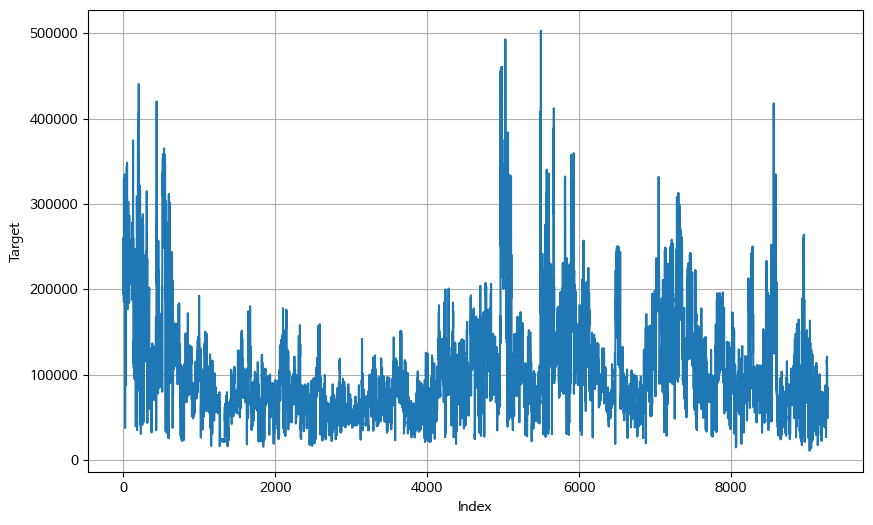

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(xgb_output['target'])
plt.xlabel('Index')
plt.ylabel('Target')
plt.grid(True)
plt.show()

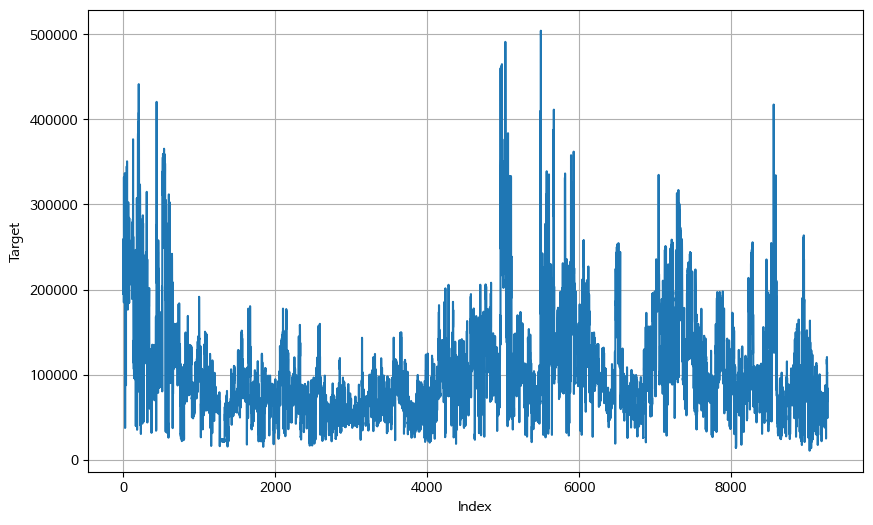

In [63]:
p_output = pd.read_csv('2500_output.csv')

plt.figure(figsize=(10, 6))
plt.plot(p_output['target'])
plt.xlabel('Index')
plt.ylabel('Target')
plt.grid(True)
plt.show()

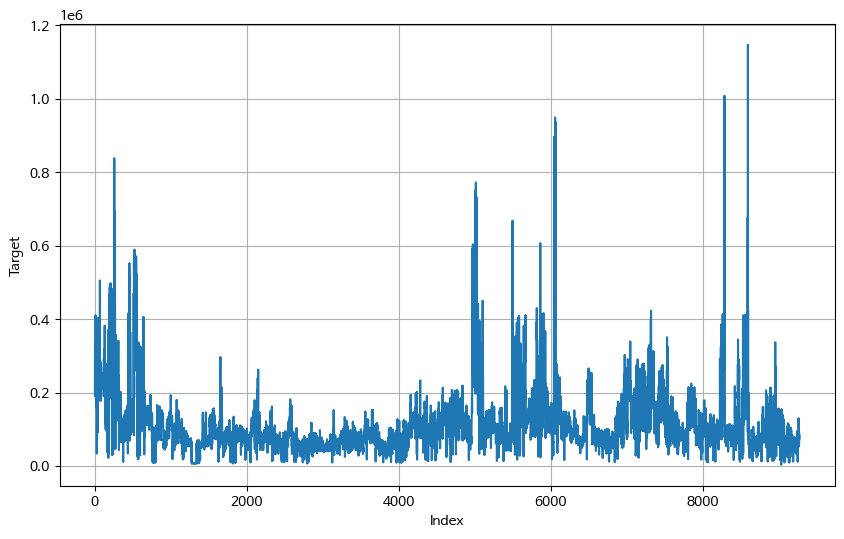

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(v_output['target'], label='v_output Target')
plt.xlabel('Index')
plt.ylabel('Target')
plt.grid(True)
plt.show()

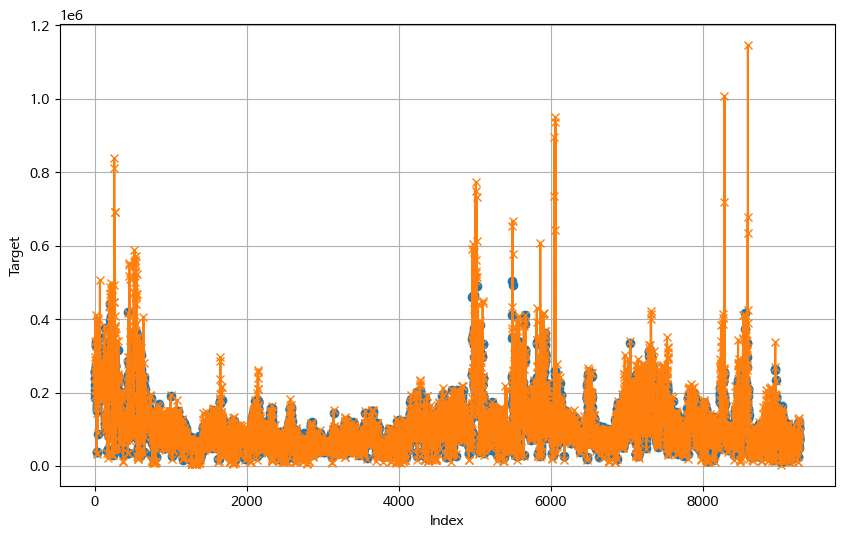

In [65]:
p_output = pd.read_csv('2500_output.csv')
v_output = pd.read_csv('v22_output.csv')
plt.figure(figsize=(10, 6))
plt.plot(p_output['target'], label='p_output Target', marker='o')
plt.plot(v_output['target'], label='v_output Target', marker='x')
plt.xlabel('Index')
plt.ylabel('Target')
plt.grid(True)
plt.show()

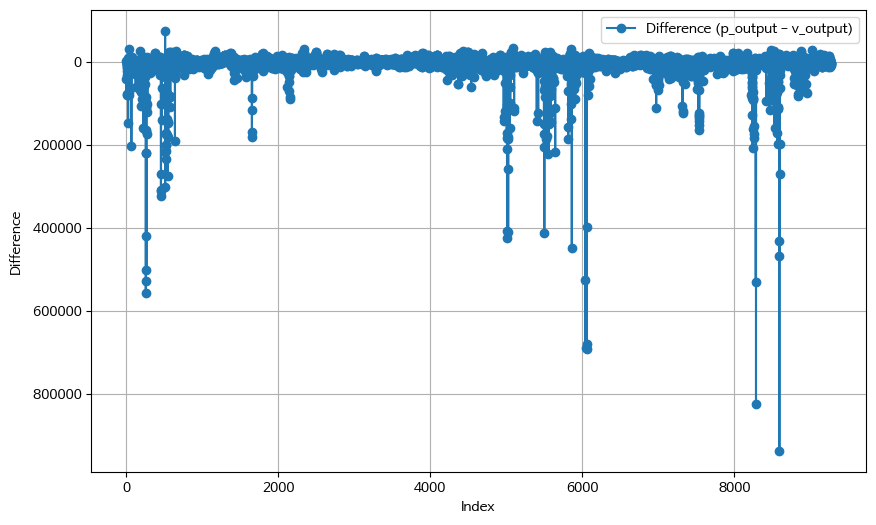

In [68]:
difference = p_output['target'] - v_output['target']

plt.figure(figsize=(10, 6))
plt.plot(difference, label='Difference (p_output - v_output)', marker='o')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.grid(True)
plt.legend()

plt.show()